<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/Xception_CIFAR100_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xception, CIFAR100

In [1]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [12]:
import os
from pprint import pprint
import argparse

import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn as sns

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = range(100) # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 32
cfg.INPUT_WIDTH = 32
cfg.INPUT_CHANNEL = 3
cfg.INPUT_MODE = 'RGB' #RGB, GRAY, CLASS_LABEL, EDGE

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'Xception'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 10_000
cfg.TRAIN.ITERATION = 10_000
#cfg.TRAIN.EPOCH = 2
cfg.TRAIN.MINIBATCH = 64
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.001, 'momentum' : 0.9} #{'lr' : 0.02, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.CrossEntropyLoss()

cfg.TRAIN.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False
cfg.TRAIN.DATA_VERTICAL_FLIP = False
cfg.TRAIN.DATA_ROTATION = False

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.csv'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data/' # 'drive/My Drive/Colab Notebooks/Dataset/test/images/
cfg.TEST.MINIBATCH = 100
cfg.TEST.ITERATION = 2
cfg.TEST.MAX_NUM = 100
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': range(0, 100),
 'CLASS_NUM': 100,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'INPUT_CHANNEL': 3,
 'INPUT_HEIGHT': 32,
 'INPUT_MODE': 'RGB',
 'INPUT_WIDTH': 32,
 'PREFIX': 'Xception',
 'TEST': {'DATA_PATH': './data/',
          'ITERATION': 2,
          'MAX_NUM': 100,
          'MINIBATCH': 100,
          'MODEL_PATH': 'models/Xception_final.pt',
          'RESULT_IMAGE_PATH': 'result/Xception_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': False,
           'DATA_PATH': './data/',
           'DATA_ROTATION': False,
           'DATA_VERTICAL_FLIP': False,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 10000,
           'LEARNING_PARAMS': {'lr': 0.001, 'momentum': 0.9},
           'LEARNING_PROCESS_RESULT_IMAGE_PATH': 'result/Xception_result_{}.jpg',
           'LEARNING_PROCESS_RESULT_INTERVAL': 500,
           'LEARNING_PROCESS_RESULT_LOSS_PATH': 'result/Xception_lo

## Define Model

In [0]:
class Xception(torch.nn.Module):
    def __init__(self):
        super(Xception, self).__init__()

        class Block(torch.nn.Module):
            def __init__(self, dim=728, cardinality=1):
                super(Block, self).__init__()

                self.block = torch.nn.Sequential(
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1, groups=cardinality),
                    torch.nn.BatchNorm2d(dim),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1, groups=cardinality),
                    torch.nn.BatchNorm2d(dim),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1, groups=cardinality),
                    torch.nn.BatchNorm2d(dim),
                )
                
            def forward(self, x):
                res_x = self.block(x)            
                x = torch.add(res_x, x)
                return x

        # Entry flow
        self.conv1 = torch.nn.Conv2d(cfg.INPUT_CHANNEL, 32, kernel_size=3, padding=1, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(32)
        
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(3, stride=2, padding=1))
        self.conv3_sc = torch.nn.Conv2d(64, 128, kernel_size=1, padding=0, stride=2)
        self.bn3_sc = torch.nn.BatchNorm2d(128)
        
        self.conv4 = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(3, stride=2, padding=1))
        self.conv4_sc = torch.nn.Conv2d(128, 256, kernel_size=1, padding=0, stride=2)
        self.bn4_sc = torch.nn.BatchNorm2d(256)
        
        self.conv5 = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 728, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(728),
            torch.nn.ReLU(),
            torch.nn.Conv2d(728, 728, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(728),
            torch.nn.MaxPool2d(3, stride=2, padding=1))
        self.conv5_sc = torch.nn.Conv2d(256, 728, kernel_size=1, padding=0, stride=2)
        self.bn5_sc = torch.nn.BatchNorm2d(728)
        
        # Middle flow
        self.middle_flow = torch.nn.Sequential(
            *[Block() for _ in range(8)]
        )
        
        # Exit flow
        self.conv_exit1 = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Conv2d(728, 728, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(728),
            torch.nn.ReLU(),
            torch.nn.Conv2d(728, 1024, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.MaxPool2d(3, stride=2, padding=1))
        self.conv_exit1_sc = torch.nn.Conv2d(728, 1024, kernel_size=1, padding=0, stride=2)
        self.bn_exit1_sc = torch.nn.BatchNorm2d(1024)
        
        self.conv_exit2 = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 1536, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(1536),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1536, 2048, kernel_size=3, padding=1, stride=1, groups=1),
            torch.nn.BatchNorm2d(2048),)
        
        self.linear = torch.nn.Linear(2048, cfg.CLASS_NUM)
        
        
    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x_sc = self.conv3_sc(x)
        x_sc = self.bn3_sc(x_sc)
        x = self.conv3(x)
        x = torch.add(x_sc, x)
        
        x_sc = self.conv4_sc(x_sc)
        x_sc = self.bn4_sc(x_sc)
        x = self.conv4(x)
        x = torch.add(x_sc, x)
        
        x_sc = self.conv5_sc(x_sc)
        x_sc = self.bn5_sc(x_sc)
        x = self.conv5(x)
        x = torch.add(x_sc, x)
        
        # Middle flow
        x = self.middle_flow(x)
        
        # Exit flow
        x_sc = self.conv_exit1_sc(x)
        x_sc = self.bn_exit1_sc(x_sc)
        x = self.conv_exit1(x)
        x = torch.add(x_sc, x)
        
        x = self.conv_exit2(x)

        x = F.avg_pool2d(x, [cfg.INPUT_HEIGHT // 32, cfg.INPUT_WIDTH // 32], padding=0, stride=1)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        #x = F.softmax(x, dim=1)
        
        return x

## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            inds = np.hstack((inds, self.inds[ : (self.batch_size - (self.data_size - self.mbi))]))
            self.mbi = self.batch_size - (self.data_size - self.mbi)
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

## Train

In [13]:
def train():
    # model
    model = Xception().to(cfg.DEVICE)
    model.train()
    
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH))
    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0, 3, 1, 2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = torch.tensor(ds.targets, dtype=torch.long).to(cfg.DEVICE)
    data_num = len(Xs_data)
    #train_ts = np.identity(cfg.CLASS_NUM)[trainset.targets] # one hot

    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    list_iter = []
    list_loss= []
    list_accuracy = []

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        # sample X and t
        mb_inds = batch_gen()
        #Xs = torch.tensor(preprocess(Xs_data[mb_inds], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        Xs = Xs_data[mb_inds]
        ts = ts_data[mb_inds]

        # forward and update
        opt.zero_grad()

        ys = model(Xs)

        loss = cfg.TRAIN.LOSS_FUNCTION(ys, ts)
        loss.backward()
        opt.step()
    
        preds = ys.argmax(dim=1, keepdim=True).reshape(-1)
        accuracy = (preds == ts).sum() / float(cfg.TRAIN.MINIBATCH)

        _loss = loss.item()
        _accuracy = accuracy.item()

        progres_bar += '|'

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')

                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accu:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save >> {}'.format(save_path))


    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3           [-1, 64, 16, 16]          18,496
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5            [-1, 128, 8, 8]           8,320
       BatchNorm2d-6            [-1, 128, 8, 8]             256
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 4, 4]          33,024
      BatchNorm2d-14            [-1, 25

## plot Loss, Accuracy

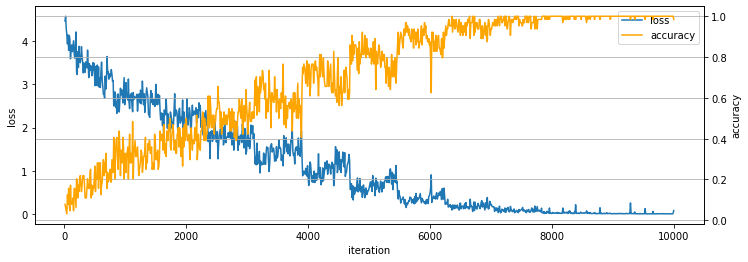

In [14]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
Files already downloaded and verified
10000 / 10000
accuracy = 0.4664
ts / pred table
array([[79.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 55.,  0., ...,  0.,  0.,  0.],
       [ 2.,  1., 37., ...,  1.,  5.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 43.,  0.,  1.],
       [ 0.,  0.,  6., ...,  1., 26.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0., 57.]])


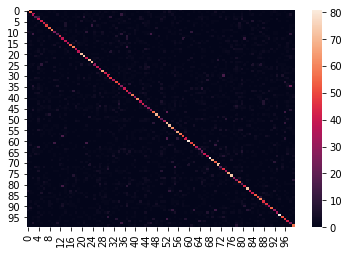

In [16]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = Xception().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    np.random.seed(0)

    ds = torchvision.datasets.CIFAR100(root=cfg.TRAIN.DATA_PATH , train=False, download=True, transform=None)
    Xs_data = torch.tensor(ds.data, dtype=torch.float).permute(0, 3, 1, 2).to(cfg.DEVICE)
    Xs_data = Xs_data / 127.5 - 1
    ts_data = np.array(ds.targets)
    data_num = len(Xs_data)
    
    table = np.zeros([cfg.CLASS_NUM, cfg.CLASS_NUM])

    inds = np.arange(data_num)

    with torch.no_grad():
        for i in range(0, data_num, cfg.TEST.MINIBATCH):
            # get batch index
            mb_inds = inds[i : min(i + cfg.TEST.MINIBATCH, data_num)]
            Xs = Xs_data[mb_inds]
            ts = ts_data[mb_inds]

            # forward
            ys = model(Xs).detach().cpu().numpy()
            ys = ys.argmax(axis=1)
            
            for t, y in zip(ts, ys):
                table[t, y] += 1

            print('\r{} / {}'.format(mb_inds[-1] + 1, data_num), end='')

    accuracy = table[np.arange(cfg.CLASS_NUM), np.arange(cfg.CLASS_NUM)].sum() / table.sum()
    print('\naccuracy =', accuracy)
    print('ts / pred table')
    pprint(table)
    sns.heatmap(table)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
